## Data

In [ ]:
# 필요한 라이브러리들 import
import numpy as np  # 수치 계산용
import pandas as pd  # 데이터 처리용
import matplotlib.pyplot as plt  # 기본 시각화
import seaborn as sns  # 고급 시각화


from sklearn.model_selection import KFold,cross_val_score, RepeatedStratifiedKFold,StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier

import optuna
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer

from sklearn.model_selection import KFold, cross_val_predict, train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score,classification_report

#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import plotly 
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import missingno as msno

import warnings
warnings.filterwarnings("ignore")

In [16]:
import pandas as pd

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 900)
pd.set_option('display.max_colwidth', 200)

df = pd.read_csv("heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
df.info()

### 데이터프레임(df)의 중복값, 결측치, 수치형 변수, 범주형 변수를 탐색하고 요약하는 전처리용 코드

In [17]:
# 중복 있나 확인
df.duplicated().sum()

np.int64(0)

In [18]:
# 각 열별로 결측치 개수와 비율을 계산
def missing (df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

missing(df)

,Missing_Number,Missing_Percent
Age,0,0.0
Sex,0,0.0
ChestPainType,0,0.0
RestingBP,0,0.0
Cholesterol,0,0.0
FastingBS,0,0.0
RestingECG,0,0.0
MaxHR,0,0.0
ExerciseAngina,0,0.0
Oldpeak,0,0.0


In [19]:
# 수치형 변수 / 범주형 변수 분리 
numerical= df.drop(['HeartDisease'], axis=1).select_dtypes('number').columns
categorical = df.select_dtypes('object').columns

print(f'Numerical Columns:  {df[numerical].columns}')
print(f'Categorical Columns: {df[categorical].columns}')

Numerical Columns:  Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'], dtype='object')
Categorical Columns: Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')


In [20]:
# 범주형 변수의 고유값 개수 확인
df[categorical].nunique()

Sex               2
ChestPainType     4
RestingECG        3
ExerciseAngina    2
ST_Slope          3
dtype: int64

## Target Variable
**버전 충돌 문제인지 히스토그램들이 보이지 않아 다른 모듈 사용했습니다...😢 : plotly API**

In [21]:
y = df['HeartDisease']
print(f'Percentage of patient had a HeartDisease:  {round(y.value_counts(normalize=True)[1]*100,2)} %  --> ({y.value_counts()[1]} patient)\nPercentage of patient did not have a HeartDisease: {round(y.value_counts(normalize=True)[0]*100,2)}  %  --> ({y.value_counts()[0]} patient)')

Percentage of patient had a HeartDisease:  55.34 %  --> (508 patient)
Percentage of patient did not have a HeartDisease: 44.66  %  --> (410 patient)


- Almost 55% of the patients had a heart disease: 508 patient had a heart disease. (비율 - 숫자)
- Almost 45% of patients didn't have a heart disease: 410 patient didn't have a heart disease.

In [23]:
import plotly.express as px
fig = px.histogram(df, x='HeartDisease', title='Heart Disease Distribution')
fig.show()

## Numerical Features

In [24]:
df[numerical].describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000


In [25]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 수치형 변수들의 히스토그램을 subplot으로 생성
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=numerical,
    specs=[[{"secondary_y": False}, {"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}, {"secondary_y": False}]]
)

for i, col in enumerate(numerical):
    row = i // 3 + 1
    col_num = i % 3 + 1
    fig.add_trace(
        go.Histogram(x=df[col], name=col, nbinsx=30),
        row=row, col=col_num
    )

fig.update_layout(height=600, showlegend=False, title_text="Numerical Features Distribution")
fig.show()

In [27]:
# 수치형 변수들의 히스토그램을 개별 subplot으로 생성 (bins=50)
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=numerical,
    specs=[[{"secondary_y": False}, {"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}, {"secondary_y": False}]]
)

for i, col in enumerate(numerical):
    row = i // 3 + 1
    col_num = i % 3 + 1
    fig.add_trace(
        go.Histogram(x=df[col], name=col, nbinsx=50),
        row=row, col=col_num
    )

fig.update_layout(height=600, showlegend=False, title_text="Numerical Features Distribution (50 bins)")
fig.show()

In [28]:
skew_limit = 0.75 # This is our threshold-limit to evaluate skewness. Overall below abs(1) seems acceptable for the linear models. 
skew_vals = df[numerical].drop('FastingBS', axis=1).skew()
skew_cols= skew_vals[abs(skew_vals)> skew_limit].sort_values(ascending=False)
skew_cols

Oldpeak    1.022872
dtype: float64

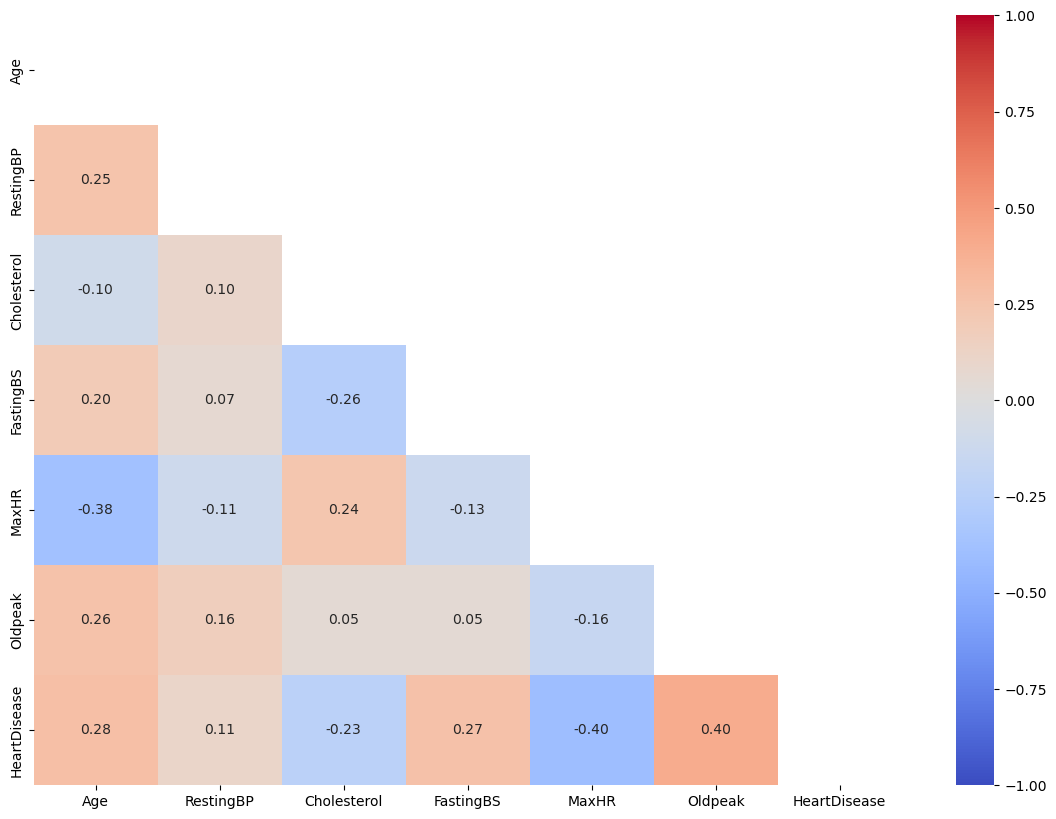

In [29]:
numerical1= df.select_dtypes('number').columns


matrix = np.triu(df[numerical1].corr())
fig, ax = plt.subplots(figsize=(14,10)) 
sns.heatmap (df[numerical1].corr(), annot=True, fmt= '.2f', vmin=-1, vmax=1, center=0, cmap='coolwarm',mask=matrix, ax=ax);

- 행렬을 기반으로 수치적 특징과 목표 변수 사이의 약한 수준 상관관계를 관찰할 수 있음.
    - 올드피크(우울증 관련 수치): 심장 질환과 양의 상관관계가 있음.
    - 최대 심박수: 심장병과 음의 상관관계가 있음.
    - 콜레스테롤: 심장병과 음의 상관관계가 있음.

## Categorical Features

In [30]:
df[categorical].head()

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
0,M,ATA,Normal,N,Up
1,F,NAP,Normal,N,Flat
2,M,ATA,ST,N,Up
3,F,ASY,Normal,Y,Flat
4,M,NAP,Normal,N,Up


### **Gender and Heart Disease**

In [31]:
print (f'A female person has a probability of {round(df[df["Sex"]=="F"]["HeartDisease"].mean()*100,2)} % have a HeartDisease')
print (f'A male person has a probability of {round(df[df["Sex"]=="M"]["HeartDisease"].mean()*100,2)} % have a HeartDisease')

A female person has a probability of 25.91 % have a HeartDisease
A male person has a probability of 63.17 % have a HeartDisease


In [32]:
fig = px.histogram(df, x="Sex", color="HeartDisease",width=400, height=400)
fig.show()

**남성: 심장 질환 가질 확률 2.44배 더 높음**

### **Chest Pain Type and Heart Disease**

In [33]:
df.groupby('ChestPainType')['HeartDisease'].mean().sort_values(ascending=False)

ChestPainType
ASY    0.790323
TA     0.434783
NAP    0.354680
ATA    0.138728
Name: HeartDisease, dtype: float64

In [34]:
fig = px.histogram(df, x="ChestPainType", color="HeartDisease",width=400, height=400)
fig.show()

- 가슴 통증 유형에 따라 명확한 차이를 관찰할 수 있음.
- ASY(무증상 가슴 통증)를 가진 사람은 ATA(비전형 협심증) 가슴 통증을 가진 사람보다 심장 질환을 가질 확률이 거의 6배 더 높음.


### **RestingECG and Heart Disease**

In [35]:
df.groupby('RestingECG')['HeartDisease'].mean().sort_values(ascending=False)

RestingECG
ST        0.657303
LVH       0.563830
Normal    0.516304
Name: HeartDisease, dtype: float64

In [36]:
fig = px.histogram(df, x="RestingECG", color="HeartDisease",width=400, height=400)
fig.show()

### **ExerciseAngina and Heart Disease**

In [37]:
df.groupby('ExerciseAngina')['HeartDisease'].mean().sort_values(ascending=False)

ExerciseAngina
Y    0.851752
N    0.351005
Name: HeartDisease, dtype: float64

In [38]:
fig = px.histogram(df, x="ExerciseAngina", color="HeartDisease",width=400, height=400)
fig.show()

ExerciseAngina: 운동 유발 협심증이 'Yes'인 경우 'No'인 경우보다 심장 질환을 가질 확률이 거의 2.4배 더 높음

### **ST_Slope and Heart Disease**

In [39]:
df.groupby('ST_Slope')['HeartDisease'].mean().sort_values(ascending=False)

ST_Slope
Flat    0.828261
Down    0.777778
Up      0.197468
Name: HeartDisease, dtype: float64

In [40]:
fig = px.histogram(df, x="ST_Slope", color="HeartDisease",width=400, height=400)
fig.show()

- ST_Slope: the slope of the peak exercise ST segment has differences.
-  ST_Slope Up significantly less likely has heart disease than the other two segment.

## Model Selection

- Logistic & Linear Discriminant & KNeighbors and Support Vector Machine models 
- ensemble models, Adaboost, Randomforest, Gradient Boosting and Extra Trees
- XGBoost,LightGBM & Catboost
- hyperparameter tuning for Catboost

### Baseline Model

In [ ]:
# 베이스라인 모델 (더미 분류기) 평가
accuracy =[]
model_names =[]

# 특성과 타겟 분리
X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
# 훈련/테스트 데이터 분할 (70:30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ohe= OneHotEncoder()
ct= make_column_transformer((ohe,categorical),remainder='passthrough')  


model = DummyClassifier(strategy='constant', constant=1)
pipe = make_pipeline(ct, model)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred),4))
print (f'model : {model} and  accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')

model_names = ['DummyClassifier']
dummy_result_df = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
dummy_result_df

model : DummyClassifier(constant=1, strategy='constant') and  accuracy score is : 0.5942


,Accuracy
DummyClassifier,0.5942


### Logistic & Linear Discriminant & SVC & KNN


In [ ]:
# 기본 분류 모델들 평가 (로지스틱, LDA, SVM, KNN)
accuracy =[]
model_names =[]

# 특성과 타겟 분리
X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
# 훈련/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ohe= OneHotEncoder()
ct= make_column_transformer((ohe,categorical),remainder='passthrough')  


lr = LogisticRegression(solver='liblinear')
lda= LinearDiscriminantAnalysis()
svm = SVC(gamma='scale')
knn = KNeighborsClassifier()

models = [lr,lda,svm,knn]

for model in models: 
    pipe = make_pipeline(ct, model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred),4))
    print (f'model : {model} and  accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')

model_names = ['Logistic','LinearDiscriminant','SVM','KNeighbors']
result_df1 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df1

model : LogisticRegression(solver='liblinear') and  accuracy score is : 0.8841
model : LinearDiscriminantAnalysis() and  accuracy score is : 0.8696
model : SVC() and  accuracy score is : 0.7246
model : KNeighborsClassifier() and  accuracy score is : 0.7174


,Accuracy
Logistic,0.8841
LinearDiscriminant,0.8696
SVM,0.7246
KNeighbors,0.7174


### Logistic & Linear Discriminant & SVC & KNN with Scaler

In [ ]:
# 스케일링을 적용한 분류 모델들 평가
accuracy =[]
model_names =[]


X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ohe= OneHotEncoder()
s= StandardScaler()
ct1= make_column_transformer((ohe,categorical),(s,numerical))  


lr = LogisticRegression(solver='liblinear')
lda= LinearDiscriminantAnalysis()
svm = SVC(gamma='scale')
knn = KNeighborsClassifier()

models = [lr,lda,svm,knn]

for model in models: 
    pipe = make_pipeline(ct1, model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred),4))
    print (f'model : {model} and  accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')

model_names = ['Logistic_scl','LinearDiscriminant_scl','SVM_scl','KNeighbors_scl']
result_df2 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df2

model : LogisticRegression(solver='liblinear') and  accuracy score is : 0.8804
model : LinearDiscriminantAnalysis() and  accuracy score is : 0.8696
model : SVC() and  accuracy score is : 0.8841
model : KNeighborsClassifier() and  accuracy score is : 0.8841


,Accuracy
Logistic_scl,0.8804
LinearDiscriminant_scl,0.8696
SVM_scl,0.8841
KNeighbors_scl,0.8841


scaler 있을 때 성능 더 좋음.

### Ensemble Models (AdaBoost & Gradient Boosting & Random Forest & Extra Trees)

In [ ]:
# 앙상블 모델들 평가 (AdaBoost, Gradient Boosting, Random Forest, Extra Trees)
accuracy =[]
model_names =[]


X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ohe= OneHotEncoder()
ct= make_column_transformer((ohe,categorical),remainder='passthrough')  

ada = AdaBoostClassifier(random_state=0)
gb = GradientBoostingClassifier(random_state=0)
rf = RandomForestClassifier(random_state=0)
et=  ExtraTreesClassifier(random_state=0)



models = [ada,gb,rf,et]

for model in models: 
    pipe = make_pipeline(ct, model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred),4))
    print (f'model : {model} and  accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')

model_names = ['Ada','Gradient','Random','ExtraTree']
result_df3 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df3

model : AdaBoostClassifier(random_state=0) and  accuracy score is : 0.8732
model : GradientBoostingClassifier(random_state=0) and  accuracy score is : 0.8768
model : RandomForestClassifier(random_state=0) and  accuracy score is : 0.8877
model : ExtraTreesClassifier(random_state=0) and  accuracy score is : 0.8696


,Accuracy
Ada,0.8732
Gradient,0.8768
Random,0.8877
ExtraTree,0.8696


- 정확도 점수는 서로 매우 비슷함. 
- 랜덤 포레스트와 엑스트라 트리 모두 비슷한 정확도 수치를 보임. 
- 두 모델 모두 하이퍼파라미터 튜닝을 통해 개선 가능.

### Famous Trio (XGBoost & LightGBM & Catboost)

In [49]:
# LightGBM, XGBoost 
accuracy =[]
model_names =[]


X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ohe= OneHotEncoder()
ct= make_column_transformer((ohe,categorical),remainder='passthrough')  

xgbc = XGBClassifier(random_state=0)
lgbmc=LGBMClassifier(random_state=0)


models = [xgbc,lgbmc]

for model in models: 
    pipe = make_pipeline(ct, model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred),4))

model_names = ['XGBoost','LightGBM']
result_df4 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df4

[LightGBM] [Info] Number of positive: 344, number of negative: 298
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 354
[LightGBM] [Info] Number of data points in the train set: 642, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.535826 -> initscore=0.143548
[LightGBM] [Info] Start training from score 0.143548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

,Accuracy
XGBoost,0.8478
LightGBM,0.8732


- With their deafult values, Catboost did better job than the other two models.

### CATBOOST

- 분류 문제에 대한 모델 학습 및 적용. 사이킷 학습 도구와의 호환성을 제공함.
- 기본 최적화 목표는 다양한 조건에 따라 상이
- Logloss: 대상 값이 두 가지만 다르거나 target_border 매개변수가 None이 아닌 경우
- MultiClass: 대상 값이 두 개 이상이며 border_count 매개변수는 None



In [ ]:
# CatBoost 기본 모델 평가
accuracy =[]
model_names =[]

# 특성과 타겟 분리
X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
# 범주형 변수 인덱스 찾기
categorical_features_indices = np.where(X.dtypes != np.float64)[0]

# 훈련/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# CatBoost 분류기 생성 (기본 설정)
model = CatBoostClassifier(verbose=False,random_state=0)

model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test))
y_pred = model.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred),4))

model_names = ['Catboost_default']
result_df5 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df5



,Accuracy
Catboost_default,0.8804


- Let's make some adjustment on the Catboost model to see its' peak performance on the problem.

### Catboost HyperParameter Tuning with Optuna

In [ ]:
# Optuna를 사용한 CatBoost 하이퍼파라미터 튜닝 함수
def objective(trial):
    # 특성과 타겟 분리
    X= df.drop('HeartDisease', axis=1)
    y= df['HeartDisease']
    # 범주형 변수 인덱스 찾기
    categorical_features_indices = np.where(X.dtypes != np.float64)[0]
    
    # 훈련/테스트 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Optuna가 최적화할 하이퍼파라미터들 정의
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),  # 목적 함수
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),  # 컬럼 샘플링 비율
        "depth": trial.suggest_int("depth", 1, 12),  # 트리 깊이
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),  # 부스팅 타입
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]  # 부트스트랩 타입
        ),
        "used_ram_limit": "3gb",  # 메모리 사용 제한
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cat_cls = CatBoostClassifier(**param)

    cat_cls.fit(X_train, y_train, eval_set=[(X_test, y_test)], cat_features=categorical_features_indices,verbose=0, early_stopping_rounds=100)

    preds = cat_cls.predict(X_test)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_test, pred_labels)
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2025-10-06 23:26:37,249] A new study created in memory with name: no-name-2623d625-faf6-4763-82ea-5776e223c702
[I 2025-10-06 23:26:38,426] Trial 0 finished with value: 0.8913043478260869 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.07077490194714353, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.383699336365299}. Best is trial 0 with value: 0.8913043478260869.
[I 2025-10-06 23:26:40,206] Trial 1 finished with value: 0.894927536231884 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.04949554580892236, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 0.894927536231884.
[I 2025-10-06 23:26:40,985] Trial 2 finished with value: 0.8768115942028986 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.030770378450401228, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.909074749038787}. Best is trial 1

Number of finished trials: 50
Best trial:
  Value: 0.8985507246376812
  Params: 
    objective: CrossEntropy
    colsample_bylevel: 0.030596450182315642
    depth: 4
    boosting_type: Ordered
    bootstrap_type: MVS


매개변수:
- Objective: 과적합 감지 및 최적 모델 선택을 위한 지원되는 지표
- colsample_bylevel: 이 매개변수는 훈련 속도를 높이며 일반적으로 품질에는 영향을 주지 않음. 
- depth: 트리의 깊이
- boosting_type: 기본적으로 부스팅 유형은 소규모 데이터셋에 대해 설정됨. 이는 과적합을 방지하지만 계산 측면에서 비용이 많이 소모. 훈련 속도를 높이기 위해 이 매개변수 값을 설정.
- bootstrap_type: 기본적으로 객체 가중치 샘플링 방법이 설정됨. 방법이 설정되고 배깅을 위한 샘플 비율 값이 1보다 작으면 훈련이 더 빠르게 수행됨.

In [ ]:
# 최적화된 CatBoost 모델 평가 (Optuna 튜닝 결과 적용)
accuracy =[]
model_names =[]

# 특성과 타겟 분리
X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
# 범주형 변수 인덱스 찾기
categorical_features_indices = np.where(X.dtypes == 'object')[0]

# 훈련/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Optuna로 최적화된 하이퍼파라미터를 적용한 CatBoost 모델
model = CatBoostClassifier(verbose=False,random_state=0,
                          objective= 'CrossEntropy',  # 최적화된 목적 함수
    colsample_bylevel= 0.04292240490294766,  # 최적화된 컬럼 샘플링 비율
    depth= 10,  # 최적화된 트리 깊이
    boosting_type= 'Plain',  # 최적화된 부스팅 타입
    bootstrap_type= 'MVS')  # 최적화된 부트스트랩 타입

model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test))
y_pred = model.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred),4))
print(classification_report(y_test, y_pred))

model_names = ['Catboost_tuned']
result_df6 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df6



              precision    recall  f1-score   support

           0       0.88      0.89      0.88       112
           1       0.93      0.91      0.92       164

    accuracy                           0.91       276
   macro avg       0.90      0.90      0.90       276
weighted avg       0.91      0.91      0.91       276



,Accuracy
Catboost_tuned,0.9058


- We have lift from 0.8804 to .9094

### Feature Importance

In [ ]:
# CatBoost 모델의 특성 중요도 분석 및 시각화
feature_importance = np.array(model.get_feature_importance())  # 특성 중요도 추출
features = np.array(X_train.columns)  # 특성 이름들
fi={'features':features,'feature_importance':feature_importance}  # 딕셔너리 생성
df_fi = pd.DataFrame(fi)  # 데이터프레임 생성
df_fi.sort_values(by=['feature_importance'], ascending=True,inplace=True)  # 중요도 순으로 정렬
# 특성 중요도 막대 그래프 생성
fig = px.bar(df_fi, x='feature_importance', y='features',title="CatBoost Feature Importance",height=500)
fig.show()

### Model Comparison

In [61]:
result_final = pd.concat([dummy_result_df,result_df1,result_df2,result_df3,result_df4,result_df5,result_df6],axis=0)

In [62]:
result_final.sort_values(by=['Accuracy'], ascending=True,inplace=True)
fig = px.bar(result_final, x='Accuracy', y=result_final.index,title='Model Comparison',height=600,labels={'index':'MODELS'})
fig.show()